In [2]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

import datetime
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
today = datetime.date.today()

In [4]:
data = yf.download('TSLA', start='2010-01-01', end=today)
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [5]:
df = data[['Close']]

dataset = df.values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i+look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # Use last 60 days to predict next day
X, y = create_dataset(scaled_data, look_back)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error',)

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

c:\Users\PMYLS\Downloads\Machine-Learning-Projects\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0079 - val_loss: 0.0025
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 9.0945e-04 - val_loss: 0.0021
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 7.2833e-04 - val_loss: 0.0020
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 7.0087e-04 - val_loss: 0.0019
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.9613e-04 - val_loss: 0.0017
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 6.3320e-04 - val_loss: 0.0018
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.3043e-04 - val_loss: 0.0015
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 7.7624e-04 - val_loss: 0.0020
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.4178e-04 - val_loss: 0.0014
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.6033e-04 - val_loss: 0.0024
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 6.0521e-04 - val_loss: 0.0018
Epoch 12/20
93/93 ━━━━━

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


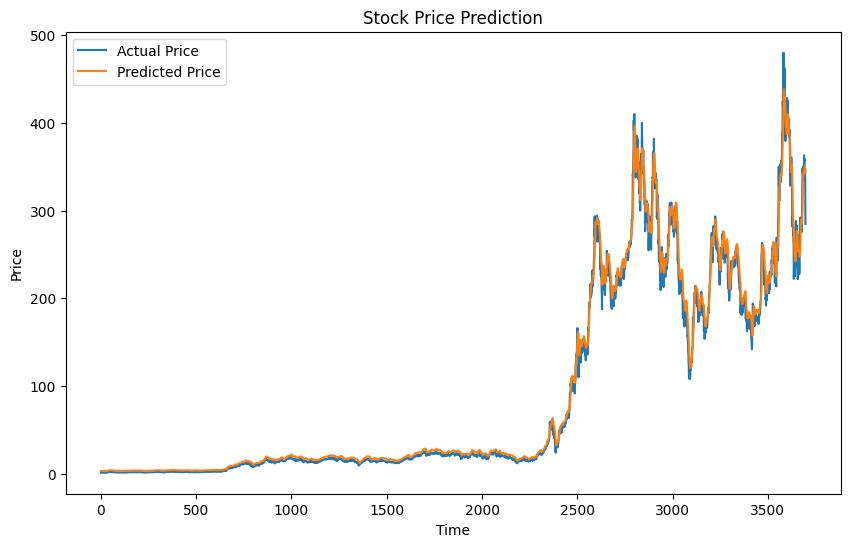

In [8]:
train_predict = model.predict(X)

train_predict = scaler.inverse_transform(train_predict)
actual = scaler.inverse_transform([y])

plt.figure(figsize=(10,6))
plt.plot(actual[0], label='Actual Price')
plt.plot(train_predict[:,0], label='Predicted Price')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [9]:
last_60_days = scaled_data[-look_back:]
next_input = last_60_days.reshape(1, look_back, 1)
next_price = model.predict(next_input)
print("Tomorrow's Predicted Price:", scaler.inverse_transform(next_price)[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tomorrow's Predicted Price: 320.65674


In [10]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test MSE: 251.7420
Test R^2 Score: 0.9421


In [11]:
import pandas as pd